In [1]:
from ECEproj4 import *
turn = 0.5/25
from numpy import matmul as matm

No RLR Path
No LRL Path
[[-15. -10.]
 [-15.   5.]]
[[-100.  -10.]
 [-100.    5.]]


In [2]:
##these blocks set up the kalman filter parameters

In [3]:
## a priori state covariance
def Pkk1_cal(Fk1, Pk1k1, Lk1):
    Pkk1 = matm(Fk1,matm(Pk1k1,Fk1.T))+matm(Lk1,Lk1.T)
    return Pkk1;

In [4]:
##innovation covariance
def Sk_cal(Hk, Pkk1, Mk):
    Sk = matm(matm(Hk,Pkk1),Hk.T)+matm(Mk,Mk.T)
    return Sk;

In [5]:
##sub-optimal kalman gain
def Kk_cal(Pkk1, Hk, Sk):
    Kk = matm(matm(Pkk1,Hk.T), np.linalg.inv(Sk))
    return Kk;

In [6]:
def f_forward(x_k1k1):
    x_kk1 = np.zeros((3,1))
    theta = x_k1k1[2]
    x_kk1[2] = theta
    x_kk1[0] = x_kk1[0]+(0.5*np.cos(theta))
    x_kk1[1] = x_kk1[1]+(0.5*np.sin(theta))
    return x_kk1;
    

In [7]:
def h_meas(x_hatkk1, radar_set):
    beta1 = np.arctan2((x_hatkk1[1]-radar_set1[0,1]),(x_hatkk1[0]-radar_set1[0,0]))
    beta2 = np.arctan2((x_hatkk1[1]-radar_set1[1,1]),(x_hatkk1[0]-radar_set1[1,0]))
    phi = x_hatkk1[2]
    y = np.zeros((3,1))
    y[0] = beta1
    y[1] = beta2
    y[2] = phi
    return y;

    
    

In [8]:
##exact innovation
def y_tildek_cal(yk, x_hatkk1, radar_set):
    #print(yk)
    #print(h_meas(x_hatkk1, radar_set))
    y_tildek = yk-h_meas(x_hatkk1, radar_set)
    return y_tildek;

In [9]:
##a priori with innovation
def x_hatkk_cal(x_hatkk1, Kk, y_tildek):
    x_hatkk = x_hatkk1+matm(Kk,y_tildek)
    #print(matm(Kk,y_tildek))
    return x_hatkk;

In [10]:
#a posteriori state covariance
def Pkk_cal(Pkk1, Kk, Sk):
    Pkk = Pkk1-matm(Kk, matm(Sk,Kk.T))
    return Pkk;

In [11]:
def Hk_cal(x_kk1, radar_set):
    y_from_m = h_meas(x_kk1, radar_set)
    beta1 = y_from_m[0]
    beta2 = y_from_m[1]
    denom1 = (1+beta1**2)*(xk-radar_set[0,0])
    denom2 = (1+beta2**2)*(xk-radar_set[1,0])
    Hk = np.eye(3)
    Hk[0,0] = -1*beta1/denom1
    Hk[0,1] = 1/denom1
    Hk[1,0] = -1*beta2/denom2
    Hk[1,1] = 1/denom2
    #Hk = np.array(([[-1*beta1/denom1, 1/denom1, 0], [-1*beta2/denom2, 1/denom2, 0], [0, 0, 1]]))
    return Hk*0.05;

In [12]:
def Fk_cal(x_kk1):
    theta = x_kk1[2]
    del_F = np.zeros((3,3))
    del_F[0,2] = np.cos(theta)
    del_F[1,2] = np.sin(theta)
    del_F[2,2] = 0.5**2/25
    return np.eye(3)+(0.5*del_F);

In [13]:
def Mk_cal():
    Mk = np.eye(3)
    Mk[0,0] = deg2rad(3)
    Mk[1,1] = deg2rad(3)
    Mk[2,2] = deg2rad(np.sqrt(5))
    return Mk*0.1;

In [14]:
def Lk_cal(x_kk1):
    theta = x_kk1[2]
    Lk = np.zeros((3,2))
    Lk[0,0] = 0.05*np.cos(theta)
    Lk[1,0] = 0.05*np.sin(theta)
    Lk[2,1] = 0.002
    return Lk*0.1;

In [15]:
def m_std(P):
    sum = (P[0,0]**2)+(P[1,1]**2)+(P[2,2]**2)
    return np.sqrt(sum);

In [16]:
Pkk = np.zeros((3,3))
Mk = Mk_cal()
Sk = np.zeros((3,3))
x_hatk1k1 = path[0,:]
print(x_hatk1k1)

[  0.         -15.           4.71238898]


In [17]:
print(path.shape)    #the true path
print(noise_path.shape)    #the noisy model transition
print(noised_path1.shape)    #the noisy measurement data

(10000, 3)
(10000, 3)
(10000, 3)


In [18]:
## initialize the measurement and the kalman path and the sk, pk stuff
p_post = np.zeros(path.shape[0])
p_post[0] = m_std(Pkk)
s_innov = np.zeros(path.shape[0])
s_innov[0] = m_std(Sk) 
x_Ekalman = np.zeros(path.shape)
y_innov = np.zeros(path.shape)
y_innov[0] = np.zeros(3)
x_Ekalman[0,:] = path[0,:]

In [19]:
## initialize the measurement and the kalman path and the sk, pk stuff
# Max's
P_priori = np.zeros(path.shape[0])
# P_posteriori = np.zeros(path.shape[0])
P_posteriori = np.zeros((path.shape[0], 3, 3))
P_posteriori[0] = np.eye(3)

p_post = np.zeros(path.shape[0])
p_post[0] = m_std(Pkk)

s_innov = np.zeros(path.shape[0])
s_innov[0] = m_std(Sk) 
x_kalman = np.zeros(path.shape)
y_innov = np.zeros(path.shape)
y_innov[0] = np.zeros(3)
x_kalman[0,:] = noise_path[0,:]


RAD_2_DEGREE = 180 / np.pi

# Max's Attempt
R = np.diag([9 / (RAD_2_DEGREE ** 2), 9 /
            (RAD_2_DEGREE ** 2), 5 / (RAD_2_DEGREE ** 2)])

Q = np.diag([0.05, 0.05, (1 / 5) ** 2 * 0.5 ** 2])


def F_k(x_k):
    
    return np.array((
        [1, 0, -0.5 * 1 * np.sin(x_k[2])],
        [0, 1, 0.5 * 1 * np.cos(x_k[2])],
        [1, 0, 1],
    ))

def H_k(x_k, radar_set):
    denom_1 = sum((x_k[i] - radar_set[0][i]) ** 2 for i in range(2))
    denom_2 = sum((x_k[i] - radar_set[1][i]) ** 2 for i in range(2))
    return np.array((
        [(-x_k[1] + radar_set[0][1]) / denom_1, (x_k[0] - radar_set[0][0]) / denom_1, 0],
        [(-x_k[1] + radar_set[1][1]) / denom_2, (x_k[0] - radar_set[1][0]) / denom_2, 0],
        [0, 0, 1],
    ))


# convert noise_path angle to radians
noise_path[:, 2] = noise_path[:, 2] * np.pi / 180


count = 0
for i in range(1, x_kalman.shape[0]):
    # this all
    if i < 2: 
        x_kk1 = noise_path[i,:]  #.reshape(3,1)        #actual model measurement
    else:
        x_kk1 = x_kalman[i - 1, :]

    z = h_meas(noised_path1[i,:].reshape(3,1), radar_set1)          #actual radar measurement
    z[2, 0] = normalize_radians(z[2, 0])
    y_exp = h_meas(x_kk1, radar_set1)
    y_exp = y_exp.reshape(3,1)

    # calculating F and H
    _F_k = F_k(x_kk1)
    _H_k = H_k(x_kk1, radar_set1)

    # calculate the priori
    P_priori = _F_k @ P_posteriori[i] @ _F_k.T + np.eye(3) @ Q @ np.eye(3).T

    # calculate the innovation
    y_k = z-y_exp

    # Innovation Covariance
    S_k = _H_k @ P_priori @ _H_k.T + np.eye(3) @ R @ np.eye(3).T

    # sub-optimal Kalman Gain
    K_k = P_priori @ _H_k.T @ np.linalg.inv(S_k)

    # a posteriori mean estimate
    x_k_k = x_kk1 + (K_k @ y_k).T
    # force it to be 1x
    x_k_k = x_k_k[0]

    # P posteriori
    P_posteriori[i] = P_priori - K_k @ S_k @ K_k.T

    ## data recording
    x_kalman[i,:] = x_k_k  # x_hatkk.reshape(3)
    y_innov[i,:] = y_k.T[0]  # y_tildek.reshape(3)
    # p_post[i] = m_std(Pkk)
    # s_innov[i] = Sk # m_std(Sk)
    #print("loop number", count)

In [23]:
Ekalman_path_intg = np.zeros((200,3))
for i in range(0,200):
    Ekalman_path_intg[i,:] = x_kalman[50*i,:]  

In [24]:
print(x_Ekalman.shape)
print(y_innov.shape)
print(p_post.shape)
print(s_innov.shape)

(10000, 3)
(10000, 3)
(10000,)
(10000,)


In [25]:
#kalman_path_intg = kalman_path_intg/4
print(Ekalman_path_intg.shape)

(200, 3)


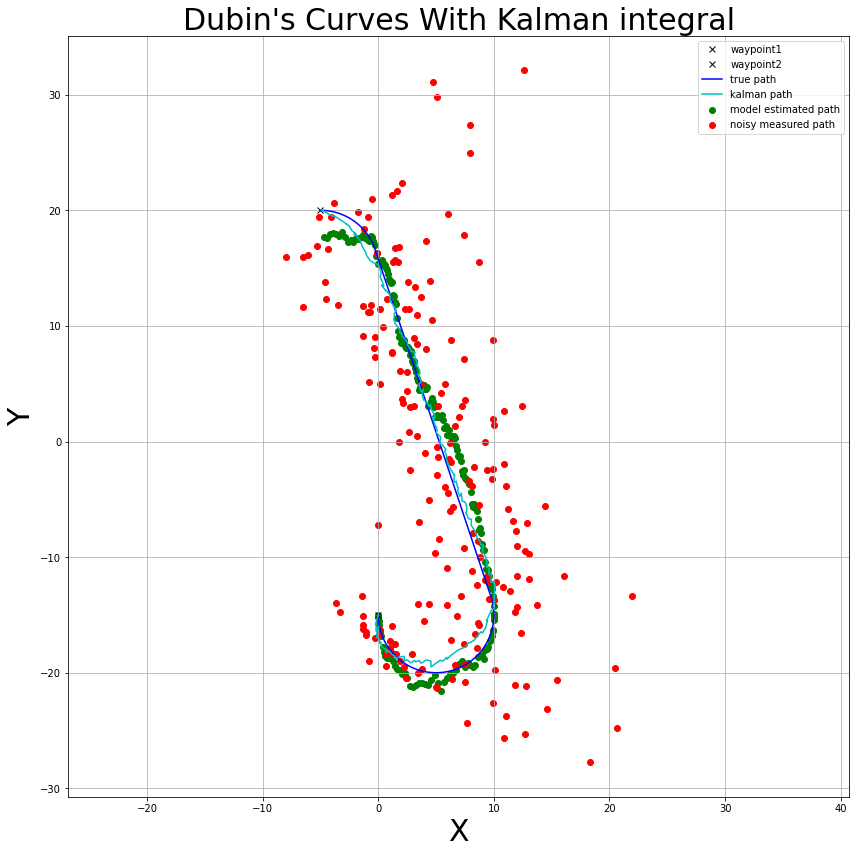

In [26]:
plt.figure(figsize=(14,14))  
plt.plot(Wptz[0].x,Wptz[0].y,'kx')
plt.plot(Wptz[1].x,Wptz[1].y,'kx')
plt.plot(path[:,0],path[:,1],'b-')    
plt.scatter(noise_path_intg[:,0], noise_path_intg[:,1], color='g')
plt.scatter(noised_path_sam1[:,0], noised_path_sam1[:,1], color='r')
plt.plot(Ekalman_path_intg[:,0], Ekalman_path_intg[:,1], color='c')
#plt.plot(x_Ekalman[:,0], x_Ekalman[:,1], color='c')

plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves With Kalman integral', fontsize='30')
plt.xlabel('X', fontsize='30')
plt.ylabel('Y', fontsize='30')
plt.legend(['waypoint1', 'waypoint2','true path', 'kalman path','model estimated path', 'noisy measured path' ])
plt.show()

In [ ]:
plt.plot(noised_path_sam1[:,2])